<a href="https://colab.research.google.com/github/FranceCawich/ColabPestDetecionCNN/blob/main/Detecion_de_pestes_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install patool

In [5]:
import patoolib

patoolib.extract_archive('/content/data.zip')




INFO patool: Extracting /content/data.zip ...
INFO:patool:Extracting /content/data.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_513oxack -- /content/data.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_513oxack -- /content/data.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/data.zip extracted to `data'.
INFO:patool:... /content/data.zip extracted to `data'.


'data'

In [7]:
pip install install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00


In [8]:
##liberias para el pre proceso de las imagenes

from keras_preprocessing.image.affine_transformations import random_brightness
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
## librerias para el modelo de nuestra red en este caso seria un modelo sequencial
from tensorflow.keras.models import Sequential
##  librerias para los layers o capas de nuestra red
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.optimizers import RMSprop

#liberias de tf y numpy y math plotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.image as mpimg
import sys
from PIL import Image
import os



In [ ]:
!pip3 install matplotlib

(390, 494, 3)

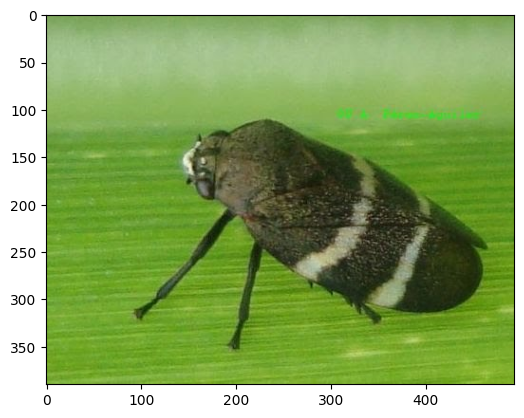

In [10]:
##ejemplo de una imagen de nuestro data set

img = image.imread("/content/data/training/moscas/24.jpg")


plt.imshow(img)

img.shape


array([[[121, 163,  89],
        [121, 163,  89],
        [121, 163,  89],
        ...,
        [117, 159,  75],
        [117, 159,  75],
        [117, 159,  75]],

       [[122, 164,  90],
        [122, 164,  90],
        [122, 164,  90],
        ...,
        [119, 161,  77],
        [119, 161,  77],
        [119, 161,  77]],

       [[125, 165,  92],
        [125, 165,  92],
        [125, 165,  92],
        ...,
        [121, 163,  81],
        [121, 163,  81],
        [121, 163,  81]],

       ...,

       [[129, 180,  62],
        [129, 180,  62],
        [129, 180,  62],
        ...,
        [124, 172,  36],
        [123, 171,  33],
        [122, 170,  32]],

       [[128, 179,  61],
        [127, 178,  60],
        [126, 177,  59],
        ...,
        [129, 175,  40],
        [129, 176,  38],
        [129, 176,  38]],

       [[124, 175,  57],
        [123, 174,  56],
        [122, 173,  55],
        ...,
        [135, 181,  46],
        [136, 183,  45],
        [136, 183,  45]]], dtype=uint8)
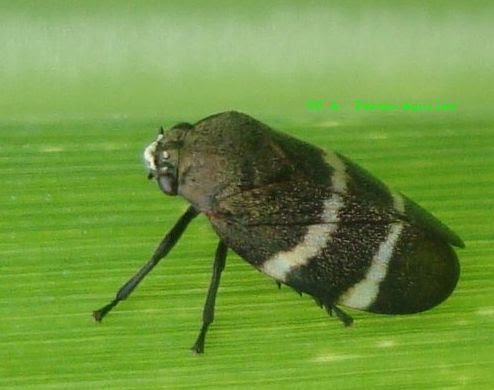

In [12]:
## conversion de una imagen rgb en una martis/ areglo de 3dimensiones para visualisar el valor
#cada pixeles de la imagen
from PIL import Image
from numpy import array
im_1 = Image.open(r"/content/data/training/moscas/24.jpg")
ar = array(im_1)
ar

In [13]:
##pre proceso de imagenes para entrenar a la red neuronal


train = ImageDataGenerator(
    rescale=1/255
)

validation = ImageDataGenerator(

    rescale=1/255
)



In [15]:
#class es binario ya que solo tenemos dos clasificacion dependiendo si el objeto esta o no esta
train_dataset = train.flow_from_directory("/content/data/training/",
                                        target_size=(200,200),
                                        batch_size= 3,
                                        class_mode="binary")

validation_dataset = train.flow_from_directory("/content/data/validation/",
                                        target_size=(200,200),
                                        batch_size= 3,
                                        class_mode="binary")

Found 31 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [ ]:
train_dataset.class_indices

{'NoExsiste': 0, 'moscas': 1}

In [16]:
##modelo de nuestra red nueronal en este caso es modelo sequencial
## con los diferentes filtos necesarios
model = tf.keras.models.Sequential([
                                    #primera capa de 16 filtros de una matris de 3 *3
                                    tf.keras.layers.Conv2D(16,(3,3),activation = 'relu', input_shape =(200,200,3)),
                                    tf.keras.layers.MaxPool2D(2,2),

                                    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPool2D(2,2),

                                    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPool2D(2,2),

                                    tf.keras.layers.Flatten(),

                                    tf.keras.layers.Dense(512,activation = 'relu'),

                                    tf.keras.layers.Dense(1,activation = 'sigmoid')

]



)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 64)        0

In [18]:
model.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])


In [19]:
from numpy import array
from PIL import Image

In [20]:
!pip3 install pillow

In [21]:

model_fit = model.fit(train_dataset , steps_per_epoch = 3 , epochs=30, validation_data=validation_dataset, validation_steps=500)

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 1.8950 - accuracy: 0.6667

3/3 [==============================] - 21s 5s/step - loss: 1.8950 - accuracy: 0.6667 - val_loss: 1.6236 - val_accuracy: 0.7308
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 0.7406 - accuracy: 0.6667
Epoch 3/30
3/3 [==============================] - 4s 1s/step - loss: 0.9523 - accuracy: 0.2222
Epoch 4/30
3/3 [==============================] - 4s 1s/step - loss: 0.5613 - accuracy: 0.7778
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 0.6559 - accuracy: 0.5556
Epoch 6/30
3/3 [==============================] - 3s 986ms/step - loss: 0.4021 - accuracy: 1.0000
Epoch 7/30
3/3 [==============================] - 4s 1s/step - loss: 0.4784 - accuracy: 0.7778
Epoch 8/30
3/3 [==============================] - 1s 435ms/step - loss: 0.2873 - accuracy: 0.8571
Epoch 9/30
3/3 [==============================] - 2s 540ms/step - loss: 0.3530 - accuracy: 0.7778
Epoch 10/30
3/3 [==============================] - 1s 420ms/step - loss: 0.1640 - accuracy: 1.0000
Epoch

In [ ]:
model.save("welcomed.h5")

In [ ]:
!pip3 install onnxmltools==1.0.0.0

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 154 kB 2.6 MB/s eta 0:00:01
  Attempting uninstall: onnxmltools
    Found existing installation: onnxmltools 1.11.0
    Uninstalling onnxmltools-1.11.0:
      Successfully uninstalled onnxmltools-1.11.0
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!pip3 install onnxruntime

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 4.9 MB 84 kB/s  eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!pip3 install tf2onnx

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 440 kB 2.5 MB/s eta 0:00:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import onnxmltools


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
input_keras_model = 'welcomed.h5'

In [ ]:
output_onnx_model = 'welcomed.onnx'

In [ ]:
keras_model = load_model(input_keras_model )

In [ ]:
!pip3 install git+https://github.com/onnx/onnxmltools

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Cloning https://github.com/onnx/onnxmltools to /tmp/pip-req-build-95ojmapa
  Running command git clone -q https://github.com/onnx/onnxmltools /tmp/pip-req-build-95ojmapa
  Created wheel for onnxmltools: filename=onnxmltools-1.11.0-py2.py3-none-any.whl size=299938 sha256=4f43dae448db0e3916f85b478b71b4128126f1abb8951dcfdbf02ec787f7e1f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-1fe7o9qc/wheels/50/c4/7f/1e8e10788e3e8af4cb1b347824d81e10123837034bde05e21e
Successfully built onnxmltools
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
onnx_model = onnxmltools.convert_keras(keras_model)

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [ ]:
onnxmltools.utils.save_model(onnx_model,output_onnx_model)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from keras_preprocessing.image import img_to_array
https://www.youtube.com/watch?v=cn8PMrIrdcs

# Load the trained model
model = load_model('your_model_path.h5')  # Load your trained model here

# Open a video capture object
video_path = 'your_video_path.mp4'  # Path to your video file
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    # Preprocess the frame
    resized_frame = cv2.resize(frame, (200, 200))
    processed_frame = img_to_array(resized_frame) / 255.0  # Normalize pixel values
    processed_frame = np.expand_dims(processed_frame, axis=0)

    # Make a prediction
    prediction = model.predict(processed_frame)
    class_label = "mosca" if prediction >= 0.5 else "no mosca"

    # Display the result on the frame
    cv2.putText(frame, class_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Video Classification', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
